# 1. Setup

## 1.1 Install Dependencies

In [ ]:
!pip install tensorflow==2.5.1 tensorflow-gpu==2.5.1 opencv-python matplotlib

## 1.2 Import Dependencies

In [ ]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
pylint 2.14.5 requires typing-extensions>=3.10.0; python_version < "3.10", but you have typing-extensions 3.7.4.3 which is incompatible.
conda-repo-cli 1.0.20 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.20 requires nbformat==5.4.0, but you have nbformat 5.5.0 which is incompatible.
bokeh 2.4.3 requires typing-extensions>=3.10.0, but you have typing-extensions 3.7.4.3 which is incompatible.
black 22.6.0 requires typing-extensions>=3.10.0.0; python_version < "3.10", but you have typing-extensions 3.7.4.3 which is incompatible.
astroid 2.11.7 requires typing-extensions>=3.10; python_version < "3.10", but you have typing-extensions 3.7.4.3 which is incompatible.


     -------------------------------------- 422.7/422.7 MB 4.5 MB/s eta 0:00:00
     -------------------------------------- 422.7/422.7 MB 2.1 MB/s eta 0:00:00
  Using cached opencv_python-4.7.0.72-cp37-abi3-win_amd64.whl (38.2 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
     -------------------------------------- 462.4/462.4 kB 7.3 MB/s eta 0:00:00
     -------------------------------------- 420.6/420.6 kB 8.7 MB/s eta 0:00:00
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     ---------------------------------------- 2.9/2.9 MB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 42.6/42.6 kB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 1.2/1.2 MB 6.6 MB/s eta 0:00:00
     -------------------------------------- 132.0/132.0 kB 8.1 MB/s eta 0:00:00
  Using cached tensorboard-2.12.0-py3-none-any.whl (5.6 MB)
  Using cached

In [ ]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [ ]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

In [ ]:
print(gpus)

[]


In [ ]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
POS_PATH

'data\\positive'

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [ ]:
#http://vis-www.cs.umass.edu/lfw/

In [ ]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [ ]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        print(os.path.join('lfw',directory,file))

## 2.2 Collect Positive and Anchor Classes

In [ ]:
# Import uuid library to generate unique image names
import uuid

In [ ]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\167ebbc0-c721-11ed-aa0e-2c3b705c1d99.jpg'

In [ ]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [ ]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(150)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(150)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(150)

In [ ]:
dir_test = anchor.as_numpy_iterator()

In [ ]:
print(dir_test.next())

b'data\\anchor\\0458f863-c722-11ed-8aee-2c3b705c1d99.jpg'


## 3.2 Preprocessing - Scale and Resize

In [ ]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [ ]:
img = preprocess('data\\anchor\\0458f863-c722-11ed-8aee-2c3b705c1d99.jpg')

In [ ]:
img.numpy().max()


1.0

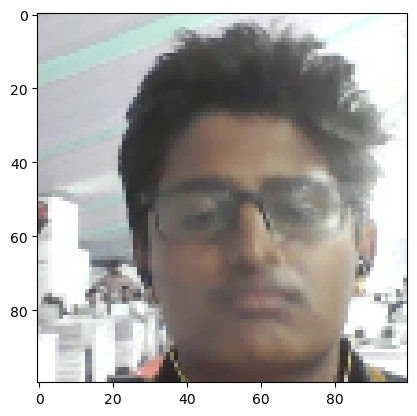

In [ ]:
plt.imshow(img)

# 3.3 Create Labelled Dataset

In [ ]:
tf.ones(len(anchor))

<tf.Tensor: shape=(150,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)>

In [ ]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [ ]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [ ]:
samples = data.as_numpy_iterator()

In [ ]:
exampple = samples.next()

In [ ]:
exampple


(b'data\\anchor\\a3989628-c721-11ed-a950-2c3b705c1d99.jpg',
 b'data\\positive\\fc8d2297-c721-11ed-9668-2c3b705c1d99.jpg',
 1.0)

# 3.4 Build Train and Test Partition

In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [ ]:
res = preprocess_twin(*exampple)

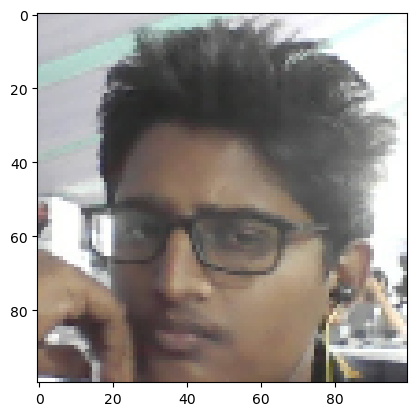

In [ ]:
plt.imshow(res[0])


In [ ]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [ ]:
samples = data.as_numpy_iterator()

In [ ]:
len(samples.next()[1])

100

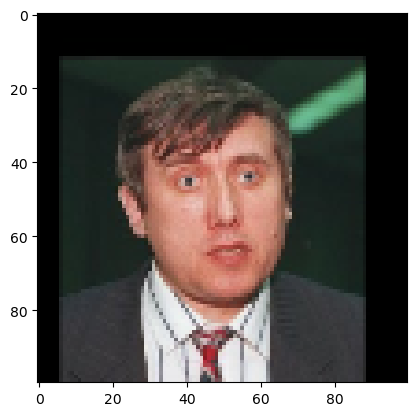

In [ ]:
plt.imshow(samples.next()[1])

In [ ]:
samp = samples.next()

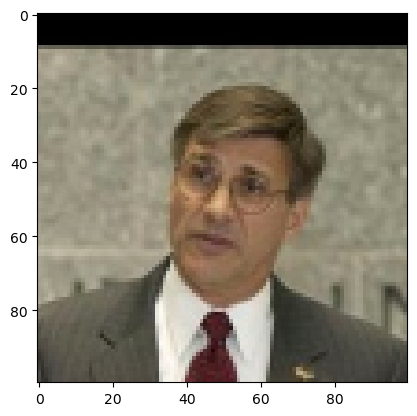

In [ ]:
plt.imshow(samp[1])

In [ ]:
samp[2]

0.0

In [ ]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [ ]:
train_data

<PrefetchDataset shapes: ((None, 100, 100, None), (None, 100, 100, None), (None,)), types: (tf.float32, tf.float32, tf.float32)>

In [ ]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [ ]:
inp = Input(shape=(100,100,3), name='input_image')

In [ ]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [ ]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [ ]:
m1

<KerasTensor: shape=(None, 46, 46, 64) dtype=float32 (created by layer 'max_pooling2d_15')>

In [ ]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [ ]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [ ]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [ ]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
mod.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 9, 9, 128)         0 

In [ ]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [ ]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 9, 9, 128)         0 

## 4.2 Build Distance Layer

In [ ]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [ ]:
l1 = L1Dist()

In [ ]:
l1(anchor_embedding,validation_embedding)

## 4.3 Make Siamese Model

In [ ]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [ ]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [ ]:
siamese_layer = L1Dist()

In [ ]:
distances = siamese_layer(inp_embedding, val_embedding)

In [ ]:
classifier = Dense(1, activation='sigmoid')(distances)

In [ ]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_7')>

In [ ]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [ ]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_2 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [ ]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [ ]:
siamese_model = make_siamese_model()

In [ ]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     

# 5. Training

## 5.1 Setup Loss and Optimizer

In [ ]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [ ]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [ ]:

test_batch = train_data.as_numpy_iterator()

In [ ]:
batch_1 = test_batch.next()

In [ ]:
X = batch_1[:2]

In [ ]:
batch_1[2]

array([0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1.],
      dtype=float32)

In [ ]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0,
    reduction='auto',
    name='binary_crossentropy',
)
Source:        
@keras_export('keras.losses.BinaryCrossentropy')
class BinaryCrossentropy(LossFunctionWrapper):
  """Computes the cross-entropy loss between true labels and predicted labels.

  Use this cross-entropy loss for binary (0 or 1) classification applications.
  The loss function requires the following inputs:

  - `y_true` (true label): This is either 0 or 1.
  - `y_pred` (predicted value): This is the model's prediction, i.e, a single
    floating-point value which either represents a
    [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
    when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
    `from_logits=False`).

  **Recommended Usage:** (set `from_logits=True`)

  With `tf.keras` API:

  ```python
  model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    

In [ ]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        y_pred = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, y_pred)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

## 5.4 Build Training Loop

In [ ]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [228]:
EPOCHS = 10
train(train_data, EPOCHS)


 Epoch 1/10
14/14 [==============================] - 151s 11s/step

 Epoch 2/10
14/14 [==============================] - 151s 11s/step

 Epoch 3/10
14/14 [==============================] - 151s 11s/step

 Epoch 4/10
14/14 [==============================] - 151s 11s/step

 Epoch 5/10
14/14 [==============================] - 3880s 298s/step

 Epoch 6/10
14/14 [==============================] - 167s 12s/step

 Epoch 7/10
14/14 [==============================] - 168s 12s/step

 Epoch 8/10
14/14 [==============================] - 165s 12s/step

 Epoch 9/10
14/14 [==============================] - 167s 12s/step

 Epoch 10/10
14/14 [==============================] - 167s 12s/step


# 6. Evaluate Model

## 6.1 Import Metrics

In [207]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [208]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [209]:
# Make predictions
y_pred = siamese_model.predict([test_input, test_val])
y_pred

array([[1.0000000e+00],
       [5.7352034e-09],
       [9.9999928e-01],
       [1.5184117e-05],
       [1.6621989e-06],
       [3.5868874e-11],
       [7.6701056e-08],
       [9.9998963e-01],
       [9.9999595e-01],
       [9.9999976e-01],
       [7.1315032e-10],
       [1.0000000e+00],
       [9.9999750e-01],
       [2.4028049e-07],
       [1.0000000e+00],
       [8.5868956e-09]], dtype=float32)

In [210]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_pred]

[1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0]

In [211]:
y_true

array([1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0.],
      dtype=float32)

## 6.3 Calculate Metrics

In [212]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_pred)

# Return Recall Result
m.result().numpy()

1.0

In [213]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_pred)

# Return Recall Result
m.result().numpy()

1.0

## 6.4 Viz Results

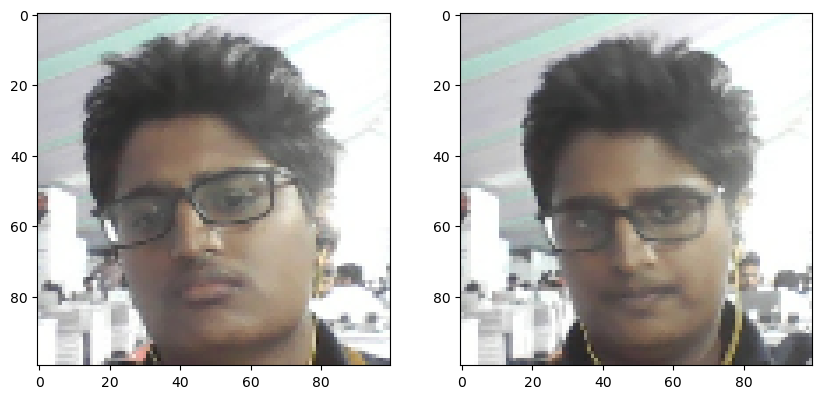

In [227]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

# 7. Save Model

In [226]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [216]:
L1Dist

__main__.L1Dist

In [217]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [218]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

array([[1.0000000e+00],
       [5.7352034e-09],
       [9.9999928e-01],
       [1.5184117e-05],
       [1.6621989e-06],
       [3.5868874e-11],
       [7.6701056e-08],
       [9.9998963e-01],
       [9.9999595e-01],
       [9.9999976e-01],
       [7.1315032e-10],
       [1.0000000e+00],
       [9.9999750e-01],
       [2.4028049e-07],
       [1.0000000e+00],
       [8.5868956e-09]], dtype=float32)

In [219]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_6 (L1Dist)              (None, 4096)         0           embedding[0][0]     

# 8. Real Time Test

## 8.1 Verification Function

In [220]:
os.listdir(os.path.join('application_data', 'verification_images'))

['c5094c8b-c721-11ed-9dc8-2c3b705c1d99.jpg',
 'c5a3c055-c721-11ed-afd0-2c3b705c1d99.jpg',
 'c6407653-c721-11ed-947c-2c3b705c1d99.jpg',
 'c65cd8d1-c721-11ed-9ec4-2c3b705c1d99.jpg',
 'c66afd3e-c721-11ed-9bfb-2c3b705c1d99.jpg',
 'c6794f40-c721-11ed-8045-2c3b705c1d99.jpg',
 'c6877cbe-c721-11ed-b97e-2c3b705c1d99.jpg',
 'c69391a7-c721-11ed-be39-2c3b705c1d99.jpg',
 'cd594ef8-c721-11ed-92fd-2c3b705c1d99.jpg',
 'cde9e7fa-c721-11ed-ac05-2c3b705c1d99.jpg',
 'cdfcf10d-c721-11ed-addf-2c3b705c1d99.jpg',
 'ce1016a3-c721-11ed-8de8-2c3b705c1d99.jpg',
 'ce2ecc87-c721-11ed-9403-2c3b705c1d99.jpg',
 'ce4b4da5-c721-11ed-9687-2c3b705c1d99.jpg',
 'ce5e57aa-c721-11ed-844e-2c3b705c1d99.jpg',
 'ce65625b-c721-11ed-b3ed-2c3b705c1d99.jpg',
 'ce73b8b3-c721-11ed-8549-2c3b705c1d99.jpg',
 'ce7b1fdd-c721-11ed-9c4c-2c3b705c1d99.jpg',
 'ce824c34-c721-11ed-8c55-2c3b705c1d99.jpg',
 'ce933fc2-c721-11ed-9d0c-2c3b705c1d99.jpg',
 'cea1579c-c721-11ed-a483-2c3b705c1d99.jpg',
 'ceafc4f8-c721-11ed-a5d9-2c3b705c1d99.jpg',
 'cebdadad

In [221]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [222]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\c5094c8b-c721-11ed-9dc8-2c3b705c1d99.jpg
application_data\verification_images\c5a3c055-c721-11ed-afd0-2c3b705c1d99.jpg
application_data\verification_images\c6407653-c721-11ed-947c-2c3b705c1d99.jpg
application_data\verification_images\c65cd8d1-c721-11ed-9ec4-2c3b705c1d99.jpg
application_data\verification_images\c66afd3e-c721-11ed-9bfb-2c3b705c1d99.jpg
application_data\verification_images\c6794f40-c721-11ed-8045-2c3b705c1d99.jpg
application_data\verification_images\c6877cbe-c721-11ed-b97e-2c3b705c1d99.jpg
application_data\verification_images\c69391a7-c721-11ed-be39-2c3b705c1d99.jpg
application_data\verification_images\cd594ef8-c721-11ed-92fd-2c3b705c1d99.jpg
application_data\verification_images\cde9e7fa-c721-11ed-ac05-2c3b705c1d99.jpg
application_data\verification_images\cdfcf10d-c721-11ed-addf-2c3b705c1d99.jpg
application_data\verification_images\ce1016a3-c721-11ed-8de8-2c3b705c1d99.jpg
application_data\verification_images\ce2ecc87-c721-11ed-9403-2c3

In [223]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [230]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+500,200:200+400, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True
True
True
True
